In [2]:
from trendAnalyserPy import StockTrendAnalyzer
from backtestPy import Backtester
from optimizerPy import Optimizer
import yfinance as yf
import numpy as np
import pandas as pd

In [3]:
class Trading:
    def __init__(self, symbol, start_date, end_date, interval, period=None):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.period = period

        # Initialize the detector with properly loaded data
        self.stock = self._load_data()
        self.detector = StockTrendAnalyzer(symbol, start_date, end_date, self.stock, interval, period)
        self.backtester = Backtester(symbol, start_date, end_date, interval, self.stock)
        self.optimizer = Optimizer(self.backtester)

        self.peaks = []
        self.throughs = []
        self.uptrends = []
        self.downtrends = []
        

    def _load_data(self):
        """
        Load stock data, considering intraday intervals with period and start_date.
        """
        if self.interval in ['1m', '2m', '5m', '15m', '30m', '60m', '90m']:  # Intraday intervals
            stock = yf.download(self.symbol, period=self.period, interval=self.interval)
            stock.reset_index(inplace=True)
            stock.rename(columns={'Datetime': 'Date'}, inplace=True)
            
            # Filter by start_date
            stock['Date'] = pd.to_datetime(stock['Date'])
            stock = stock[stock['Date'] >= pd.to_datetime(self.start_date)]
        else:  # Daily or higher intervals
            stock = yf.download(self.symbol, start=self.start_date, end=self.end_date, interval=self.interval)
            #stock.columns = stock.columns.droplevel(1)

        print("Data loaded successfully.")
        return stock

    def analyze_stock(self):
        """
        Analyze stock trends for the initialized symbol and time period.
        """
        analyzer = self.detector
        analyzer.data = self.stock  # Ensure detector works with the loaded data
        self.peaks, self.troughs = analyzer.find_peaks_and_troughs()
        self.uptrends, self.downtrends = analyzer.identify_trends()
        
        # Generate visualization
        #plt = analyzer.visualize_trends()
        #plt.show()
        
        # Print trend summary
        print(f"\nTrend Summary for {self.symbol}:")
        for summary in analyzer.get_trend_summary():
            print(summary)
        
        return analyzer

    def analyze_and_backtest(self, analyzer, strategy=None, **params):
        """
        Perform analysis to find peaks and troughs, and then backtest using the results.
        """
        # Step 1: Analyze data to find peaks and troughs
        peaks = analyzer.peaks
        troughs = analyzer.troughs
        uptrends = analyzer.uptrends
        downtrends = analyzer.downtrends
    
        # Step 2: Update params with peaks and troughs
        params["peaks"] = peaks
        params["troughs"] = troughs
        params["uptrends"] = uptrends
        params["downtrends"] = downtrends
    
        # Step 3: Initialize Backtester with data and params
        backtester = Backtester(
            symbol=self.symbol,
            start_date=self.start_date,
            end_date=self.end_date,
            interval=self.interval,
            data=self.stock,
            initial_capital=10000,
            strategy=strategy,
            **params
        )
    
        # Step 4: Run the backtest and return results
        results = backtester.backtest()
        plt = backtester.visualize_data()
        plt.show()
        backtester.print_results(results)
        return backtester
        
    def optimize(self, strategy, param_ranges, initial_guess):
        """
        Optimize trading strategy parameters.
        """
        backtester = Backtester(self.stock)
        optimizer = Optimizer(backtester)
        return optimizer.optimize(strategy, param_ranges, initial_guess)


[*********************100%%**********************]  1 of 1 completed


Data loaded successfully.

Trend Summary for SPY:
Uptrend: Start: 2024-01-31 (Price: $482.88), End: 2024-04-04 (Price: $513.07), Change: 6.3%
Uptrend: Start: 2024-05-02 (Price: $505.03), End: 2024-05-23 (Price: $525.96), Change: 4.1%
Uptrend: Start: 2024-08-28 (Price: $558.30), End: 2024-09-03 (Price: $552.08), Change: -1.1%
Uptrend: Start: 2024-09-20 (Price: $568.25), End: 2024-10-31 (Price: $568.64), Change: 0.1%
Uptrend: Start: 2024-10-29 (Price: $581.77), End: 2024-11-01 (Price: $571.04), Change: -1.8%
Uptrend: Start: 2024-11-20 (Price: $590.50), End: 2024-12-05 (Price: $606.66), Change: 2.7%
Downtrend: Start: 2024-04-09 (Price: $519.32), End: 2024-04-26 (Price: $508.26), Change: -2.1%
Downtrend: Start: 2024-05-28 (Price: $529.81), End: 2024-06-05 (Price: $534.67), Change: 0.9%
Downtrend: Start: 2024-07-23 (Price: $553.78), End: 2024-08-19 (Price: $559.61), Change: 1.1%


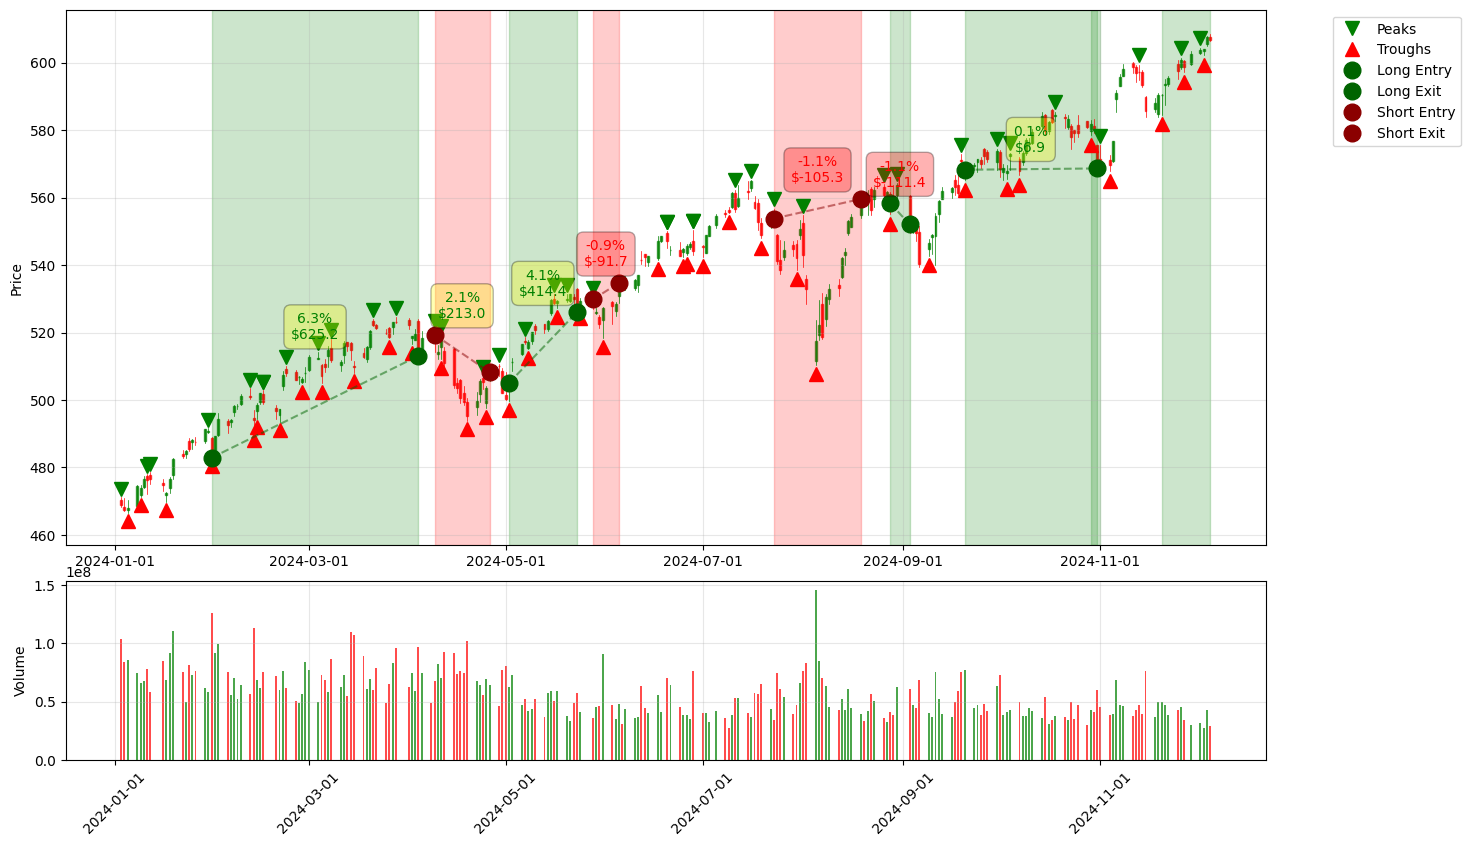


BACKTEST RESULTS
Symbol:                  SPY			Buy & Hold Net Profit:   $ 294097.49
Start Date:              2024-01-03		Buy & Hold Profit:     29.41%
End Date:                2024-12-10
------------------------------------------------------------------------------------------------------------------------
Interval:                1d			Strategy Profit:      $ 951.06
Start Date Capital:      10000			Strategy Yield:       9.51 %
End Date Capital:        10951.057112951261
Strategy Name:           trend_strategy
Metric                                        Total                      Long                     Short
------------------------------------------------------------------------------------------------------------------------
Profits                                   $1259.47                  $1046.5                  $212.97
Losses                                  ($-308.42)               ($-111.41)               ($-197.01)
Net Profit                                 $951.06      

In [4]:
symbol='SPY'
start_date='2024-01-03' 
end_date='2024-12-10'
period='1d'
interval='1d'
trading = Trading(symbol, start_date, end_date, interval=interval, period=period)
analyzer = trading.analyze_stock()
backtest = trading.analyze_and_backtest(analyzer)

In [4]:
backtest.tradesInfo

[{'type': 'long',
  'entry_price': 482.8800048828125,
  'exit_price': 513.0700073242188,
  'entry_idx': 19,
  'exit_idx': 63,
  'profit_percent': 6.252071350258724,
  'profit_money': 625.2071350258724,
  'open_date': Timestamp('2024-01-31 00:00:00'),
  'close_date': Timestamp('2024-04-04 00:00:00')},
 {'type': 'short',
  'entry_price': 519.3200073242188,
  'exit_price': 508.260009765625,
  'entry_idx': 66,
  'exit_idx': 79,
  'profit_percent': 2.129707579644402,
  'profit_money': 212.9707579644402,
  'open_date': Timestamp('2024-04-09 00:00:00'),
  'close_date': Timestamp('2024-04-26 00:00:00')},
 {'type': 'long',
  'entry_price': 505.0299987792969,
  'exit_price': 525.9600219726562,
  'entry_idx': 83,
  'exit_idx': 98,
  'profit_percent': 4.144312861404101,
  'profit_money': 414.43128614041007,
  'open_date': Timestamp('2024-05-02 00:00:00'),
  'close_date': Timestamp('2024-05-23 00:00:00')},
 {'type': 'short',
  'entry_price': 529.8099975585938,
  'exit_price': 534.6699829101562,
  '

In [5]:
analyzer.uptrends

[(19, 63), (83, 98), (164, 167), (180, 209), (207, 210), (223, 233)]